# Syrtis Demonstration - Martian Environment
# Heat Loss from a Mars Direct-style Habitat on the Martian Surface

This example demonstrates the full thermal solution system of Syrtis, working as intended on the surface of Mars. Our Habitat design based on the Mars Direct Hab with wall thickness based on the ISS Destiny module. This uses a thin aluminium wall with multiple spaced layers of thin polymer to act as a Whipple MMOD shield. Details of this shield can be found in [this paper](https://ntrs.nasa.gov/api/citations/20060026214/downloads/20060026214.pdf). The Hab is placed at the Martian solar equator at local noon (sun directly overhead).

Many proposals for human Mars missions (noteably, Mars Direct) have the surface habitat transit to Mars without the benefit of a closed aeroshell. As such, the MMOD protection will be retained in our model. For a vertical configuration, landing legs with an arbitrary thermal resistance are added to account for ground conduction. However, for a horizontally-oriented module we must use a more mechanically rigid layer to support the habitat as it rests on the outer skin. A generic polyurethane foam replaces the 50mm airgap between the layers of the MMOD shield.

In [1]:
from syrtis import *
from syrtis.configuration import Configuration
from syrtis.solver import Solver
from syrtis.material import Solid, ConstrainedIdealGas
from syrtis.habitat import Habitat
import numpy as np
import matplotlib.pyplot as plt

### Setup and Configuration
The syrtis modules are imported. The three solid materials used (aluminium, a generic plastic and open-cell foam) and two gases are created. 

The baseline Configuration is created - later, ConfigurationManagers will be used to iterate through a range of habitat temperatures (`T_hab`) to obtain a performance chart.

In [2]:
# Materials definitions
# The absorbivity of perlite and air are assumed as 0.5 but are not required
aluminium = Solid("Aluminium", 247, 2700, 900, 0.15)
plastic = Solid("Generic plastic", 10, 1300, 1420, 0.5)
open_cell_foam = Solid("Generic open-cell polyurethane foam", 0.036, 10, 1500, 0.5)

internal_air = ConstrainedIdealGas("STP CO2", 101325, 29, 0.71, 10.9e-6, 749, 0.0153)
martian_air = ConstrainedIdealGas("Martian ambient pressure CO2", 580, 44, 0.71, 10.9e-6, 749, 0.0153)

equator = Configuration("Martian equator at noon",
 "constant temperature", 210, 0.1, 0.29, 210, 580, 1, "cross", 90, 90, 605, T_habitat=290)

## Vertically-Oriented Geometry

A geometry for the Hab in a vertical orientation is created. The outer diameter is around 9m, as per Robert Zubrin's original plan. The wall cross-section matches that of the Destiny ISS module. An inner 4.8mm aluminium skin holds pressure, followed by two 5cm gaps separated by a 2mm layer of plastic. On Destiny this is a Nomex/Kevlar composite for appropriate MMOD protection but for thermal properties a generic plastic is used.

To represent the structure separating the gaps, a parallel thermal resistance is included. This value is hand-calculated, and is equal to filling 1% of the cross section with aluminium.

The thermal resistance to the ground is estimated, through a generic set of six landing leg struts. These are assumed to be made of aluminium, with a 50cm2 cross section and 5m of length.

In [3]:
HAB_vertical = Habitat(orientation="vertical", length=6, endcap_type="flat")

HAB_vertical.create_static_shell(internal_air, 4.400)
HAB_vertical.create_static_shell(aluminium, 4.8e-3)

HAB_vertical.create_static_shell(martian_air, 50e-3, parallel_thermal_resistance=8.5e-5)
# Parallel resistance corresponds to 1% of the cross-section being aluminium

HAB_vertical.create_static_shell(plastic, 12e-3)
HAB_vertical.create_static_shell(martian_air, 50e-3, parallel_thermal_resistance=8.4e-5)

HAB_vertical.create_static_shell(aluminium, 2e-3)

HAB_vertical.create_ground_level(habitat_axis_height=2, thermal_resistance=1)
# Thermal resistance roughly corresponds to six aluminium landing legs, each 5m long and with 50cm2 area

## Horizontally-oriented Geometry

The horizontally-lying habitat uses a similar geometry with some slight changes. As the skin of the habitat must now support the weight of the soil, the air gaps are filled with a foam-like material and the reinforcement structure must be increased. The foam is represented with open-cell polyurethane foam, and the aluminium cross-section fill (see above) is increased from 1% to 5%.

Unlike the vertical case, which rests on landing legs, the bottom of the horizontal habitat is embedded in the ground. In fact, 3.4m of useable space is below ground level. This could plausibly be used for crew quarters as it would experience less cosmic ray-originated radiation.

In [4]:
HAB_horizontal = Habitat(orientation="horizontal", length=6, endcap_type="flat")

HAB_horizontal.create_static_shell(internal_air, 4.400)
HAB_horizontal.create_static_shell(aluminium, 4.8e-3)

HAB_horizontal.create_static_shell(open_cell_foam, 50e-3, parallel_thermal_resistance=1.7e-5)
# Parallel resistance corresponds to 5% of the cross-section being aluminium

HAB_horizontal.create_static_shell(plastic, 12e-3)
HAB_horizontal.create_static_shell(open_cell_foam, 50e-3, parallel_thermal_resistance=1.7e-5)

HAB_horizontal.create_static_shell(aluminium, 2e-3)

HAB_horizontal.create_ground_level(habitat_axis_height=1)

## Configuration Creation

Configurations for both the vertical and horizontal cases are created and executed

In [5]:
cm_vertical = ConfigurationManager(HAB_vertical, equator, {"T_habitat":list(range(273, 313))})
configs_vertical, heats_vertical, reports_vertical = cm_vertical.run_all_configurations(verbose=True)


In [6]:
cm_horizontal = ConfigurationManager(HAB_horizontal, equator, {"T_habitat":list(range(273, 313))})
configs_horizontal, heats_horizontal, reports_horizontal = cm_horizontal.run_all_configurations(verbose=True)

In [7]:
habitat_temps = [(config["T_habitat"]-273) for config in configs_vertical]

## Results

The initial results set is the power loss-temperature plot. These show the range of heat dissipations for a given internal wall temperature, based on an extended habitable range.

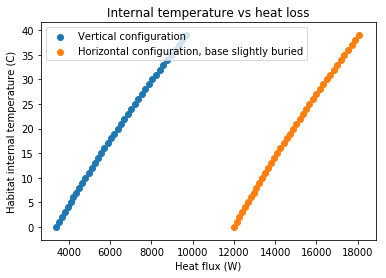

In [8]:
plt.scatter(heats_vertical, habitat_temps, label="Vertical configuration")
plt.scatter(heats_horizontal, habitat_temps, label="Horizontal configuration, base slightly buried")

plt.xlabel("Heat flux (W)")
plt.ylabel("Habitat internal temperature (C)")
plt.title("Internal temperature vs heat loss")

plt.legend()
plt.show()

In [13]:
#vertical_report_293 = [reports_vertical[i] for i in range(len(reports_vertical)) 
#if (configs_vertical[i]["T_habitat"] == 293)]



[3381.3826472603955, 3517.9265003703285, 3655.698714657821, 3794.707616921736, 3934.961574001004, 4076.4689466161403, 4219.238084694576, 4363.277379839309, 4508.595224333073, 4655.200033481797, 4803.100196026711, 4952.30416084407, 5102.8203346875825, 5254.657188243809, 5407.823145413017, 5562.32669790923, 5718.176302219028, 5875.380421362611, 6033.947577288057, 6193.886250868133, 6355.204947572385, 6517.912161468078, 6682.016452214392, 6847.526330083752, 7014.450331573476, 7182.797000405912, 7352.574887314806, 7523.792549830769, 7696.458552066469, 7870.581439319129, 8046.169837787918, 8223.23230563707, 8401.777431148143, 8581.813808102854, 8763.350035565174, 8946.39471766325, 9130.956463370636, 9317.043918196288, 9504.665637230351, 9693.830273688536]
